In [1]:
import pandas as pd
import numpy as np

In [2]:
WINDOW = 10

### Problem definition
Given the opening and closing prices from the last 10 trading days, and the opening price from the current day, predict whether the closing price will be higher or lower than the opening price

### Data collection
Tesla stock price dataset obtained from Kaggle

In [4]:
df_all_data = pd.read_csv("./Resources/TSLA.csv")
df_all_data["Date"] = pd.to_datetime(df_all_data["Date"])
df_all_data.set_index("Date", inplace=True)
df_all_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999
...,...,...,...,...,...,...
2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010


### Data cleaning and preprocessing
- Constrain to opening and closing prices only
- Use sliding window to obtain 21 features
- Scale data to standard normal distribution

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
df_constrained = df_all_data.loc[:, ["Open", "Close"]]
split_point = int(len(df_constrained) * 0.85)
df_training = df_constrained.iloc[:split_point, :]
df_test = df_constrained.iloc[split_point:, :]

In [7]:
def sliding_window(df):
    data = []
    for i in range(WINDOW, len(df)):
        opening = df.iloc[i-WINDOW:i, 0].to_list()
        closing = df.iloc[i-WINDOW:i, 1].to_list()
        datapoint = [price for pair in zip(opening, closing) for price in pair]
        current_open = df.iloc[i, 0]
        datapoint.append(current_open)
        current_close = df.iloc[i, 1]
        if current_open >= current_close:
            datapoint.append(1.)
        else:
            datapoint.append(0.)
        data.append(datapoint)
    return np.array(data)

In [8]:
np_training = sliding_window(df_training)
np_test = sliding_window(df_test)

In [9]:
X_train = np_training[:, :-1]
y_train = np_training[:, -1]
X_test = np_test[:, :-1]
y_test = np_test[:, -1]

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

### EDA

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

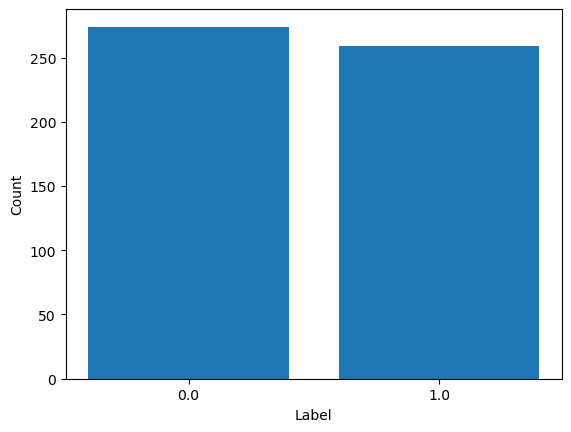

In [12]:
counts = Counter(y_train)
counts = {str(key): value for key, value in counts.items()}
fig, ax = plt.subplots()
ax.bar(counts.keys(), counts.values())
ax.set_xlabel("Label")
ax.set_ylabel("Count")
plt.show()

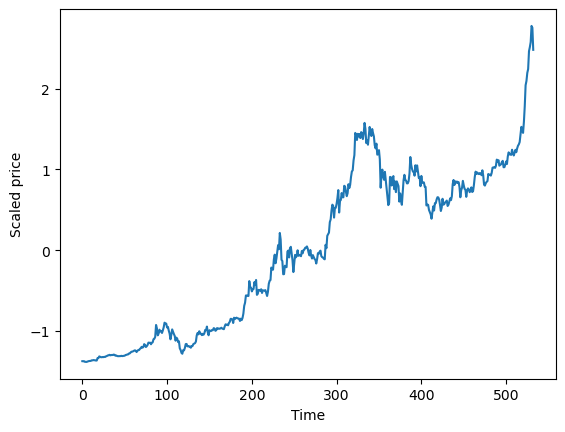

In [13]:
fig, ax = plt.subplots()
ax.plot(np.r_[:len(X_train)], X_train[:, 0])
ax.set_xlabel("Time")
ax.set_ylabel("Scaled price")
plt.show()

### Feature engineering
None for v0.1.0

### Model selection
Using PyTorch via Keras for v0.1.0

### Model training

In [14]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import torch
import keras
from keras import layers
from keras import callbacks

from sklearn.metrics import classification_report

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [15]:
def get_model(input_dim, input_drop, hidden_drop, noise):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.GaussianNoise(noise),
        layers.Dropout(input_drop),
        layers.Dense(16),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(hidden_drop),
        layers.Dense(8),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(hidden_drop),
        layers.Dense(4),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(hidden_drop),
        layers.Dense(1, activation="sigmoid")
    ])
    model.to(device)
    return model

In [16]:
def get_early_stop():
    early_stop = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=50,
        restore_best_weights=True
    )
    return early_stop

In [22]:
split_point = int(len(X_train) * 0.85)
X_epoch = X_train[:split_point, :]
y_epoch = y_train[:split_point]
X_validate = X_train[split_point:, :]
y_validate = y_train[split_point:]

input_drop = 0.02
hidden_drop = 0.3
noise = 0.001
learning_rate = 1e-4
weight_reg = 1e-4

optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_reg)

model = get_model(21, input_drop, hidden_drop, noise)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_epoch, y_epoch, epochs=1000, batch_size=32, validation_data=(X_validate, y_validate), validation_batch_size=32, callbacks=[get_early_stop()])

epoch_losses = history.history["loss"]
validation_losses = history.history["val_loss"]

model.save("./Resources/model.keras")

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4768 - loss: 0.7953 - val_accuracy: 0.4375 - val_loss: 0.7000
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.7754 - val_accuracy: 0.4750 - val_loss: 0.6987
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4967 - loss: 0.7865 - val_accuracy: 0.4625 - val_loss: 0.6991
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5166 - loss: 0.7545 - val_accuracy: 0.4375 - val_loss: 0.7003
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4879 - loss: 0.8113 - val_accuracy: 0.4625 - val_loss: 0.7000
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4702 - loss: 0.8158 - val_accuracy: 0.4500 - val_loss: 0.7004
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4746 - loss: 0.7687 - val_accuracy: 0.4375 - val_loss: 0.7027
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4857 - loss: 0.7744 - val_accu

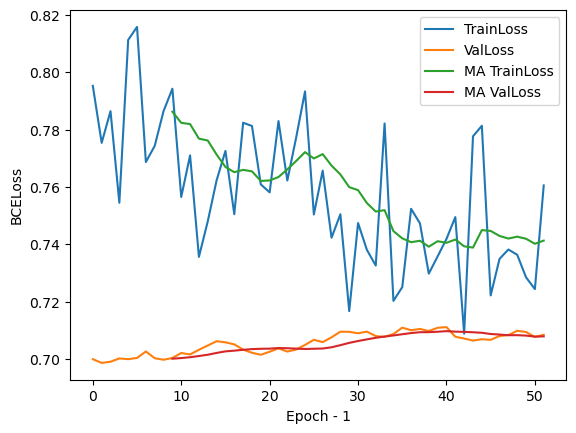

In [23]:
fig, ax = plt.subplots()
df_losses = pd.DataFrame(zip(epoch_losses, validation_losses), columns=["TrainLoss", "ValLoss"])
df_losses["MA TrainLoss"] = df_losses["TrainLoss"].rolling(window=10).mean()
df_losses["MA ValLoss"] = df_losses["ValLoss"].rolling(window=10).mean()
df_losses.plot.line(ax=ax)
ax.set_xlabel("Epoch - 1")
ax.set_ylabel("BCELoss")
ax.legend()
plt.show()

### Model evaluation and tuning
No tuning for v0.1.0

In [29]:
predictions = model.predict(X_test, batch_size=32).flatten()
y_pred = (predictions > 0.5).astype(int)
y_test = y_test.astype(int)
report = classification_report(y_test, y_pred, zero_division=np.nan)
print(report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
              precision    recall  f1-score   support

           0       0.83      0.11      0.19        46
           1       0.49      0.97      0.65        40

    accuracy                           0.51        86
   macro avg       0.66      0.54      0.42        86
weighted avg       0.67      0.51      0.41        86

